In [1]:
import sys
sys.path.append('../libs')

from esnlib import *
import pandas as pd

from sklearn import preprocessing
import sklearn.metrics as metrics

import sklearn.model_selection as ms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.Series.from_csv('../../data/meteo.csv')[:1000]

prediction_steps = 12
input_steps = 12
train_perc = 0.8

X,y = getDataWindowed(data,input_steps,prediction_steps)

trainlen = int(train_perc*len(X))
X_train,X_test = X[:trainlen], X[trainlen:]
y_train,y_test = y[:trainlen], y[trainlen:]

In [3]:
minmax_in = preprocessing.MinMaxScaler(feature_range=(-1,1)) 
standarization_in = preprocessing.StandardScaler()
minmax_out = preprocessing.MinMaxScaler(feature_range=(-1,1)) 
standarization_out = preprocessing.StandardScaler()

minmax_in.fit(X_train)
minmax_out.fit(y_train)
standarization_in.fit(X_train)
standarization_out.fit(X_train)
preproc_in = standarization_in
preproc_out = standarization_out

In [4]:
X_train = preproc_in.transform(X_train) if preproc_in else X_train
X_test = preproc_in.transform(X_test) if preproc_in else X_test

y_train = preproc_out.transform(y_train) if preproc_out else y_train
y_test = preproc_out.transform(y_test) if preproc_out else y_test

In [5]:
def scorer(estimator, X,y):
    y_pred = estimator.predict(X,cont=True)
    #return metrics.r2_score(y,y_pred)
    return -metrics.mean_squared_error(y,y_pred)

tscv = ms.TimeSeriesSplit(n_splits=5)
clf = ESN(random_state=42,n_reservoir=1000)
params = {'spectral_radius':np.linspace(0,1,5), 'sparsity':np.linspace(0.1,0.99,5), 'leaking_rate':np.linspace(0,1,5)}
cv = ms.GridSearchCV(clf,params, n_jobs=-1, cv=tscv, verbose=True, scoring=scorer, iid=False)
cv.fit(X_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:  5.8min finished


GridSearchCV(cv=TimeSeriesSplit(n_splits=5), error_score='raise',
       estimator=ESN(activation=<ufunc 'tanh'>, leaking_rate=0.3, n_reservoir=1000,
  random_state=<mtrand.RandomState object at 0x7f7c534ac3f0>,
  regularization=1, sparsity=0, spectral_radius=0.135),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'spectral_radius': array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ]), 'sparsity': array([ 0.1   ,  0.3225,  0.545 ,  0.7675,  0.99  ]), 'leaking_rate': array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x7f7c527358c8>, verbose=True)

In [6]:
cv.best_params_

{'leaking_rate': 0.0, 'sparsity': 0.10000000000000001, 'spectral_radius': 0.0}

In [7]:
clf.set_params(**cv.best_params_)

ESN(activation=<ufunc 'tanh'>, leaking_rate=0.0, n_reservoir=1000,
  random_state=<mtrand.RandomState object at 0x7f7c534ac3f0>,
  regularization=1, sparsity=0.10000000000000001, spectral_radius=0.0)

In [8]:
clf.fit(X_train,y_train)

ESN(activation=<ufunc 'tanh'>, leaking_rate=0.0, n_inputs=12, n_outputs=12,
  n_reservoir=1000,
  random_state=<mtrand.RandomState object at 0x7f7c534ac3f0>,
  regularization=1, sparsity=0.10000000000000001, spectral_radius=0.0)

In [9]:
y_pred = clf.predict(X_test)

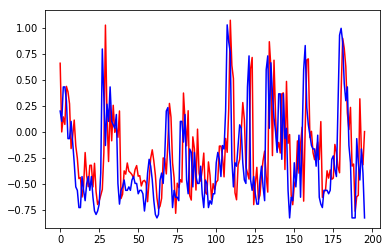

In [10]:
plt.plot(y_pred[:,0],'r')
plt.plot(y_test[:,0],'b')

In [11]:
import sklearn.metrics as metrics

In [12]:
metrics.mean_absolute_error(y_test,y_pred)

0.40198693193686036

In [13]:
metrics.mean_squared_error(y_test[:,11],y_pred[:,11])

0.24635920763274136

In [ ]:
#cv.cv_results_

In [ ]:
regressors_params = []
def scorer(estimator, X,y):
    y_pred = estimator.predict(X,cont=True)
    #return metrics.r2_score(y,y_pred)
    return -metrics.mean_squared_error(y,y_pred)

for i in [11]:#range(12):
    tscv = ms.TimeSeriesSplit(n_splits=5)
    clf = ESN(random_state=42,n_reservoir=100)
    params = {'regularization':np.linspace(1e-5,1,3),'spectral_radius':np.linspace(0,1,5), 'sparsity':np.linspace(0.1,0.99,5), 'leaking_rate':np.linspace(0,1,5)}
    cv = ms.GridSearchCV(clf,params, n_jobs=-1, cv=tscv, verbose=True, scoring=scorer, iid=False)
    cv.fit(X_train,y_train[:,i])
    regressors_params.append(cv.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   59.6s


In [ ]:
clf.set_params(**regressors_params[0])

In [ ]:
clf.fit(X_train,y_train[:,11])
y_pred=clf.predict(X_test)

In [ ]:
plt.plot(y_pred)
plt.plot(y_test[:,11])